In [1]:
# add folders to current working path

In [2]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# Overview

In the following notebook we compute the Poincaré Map of the three-dimensional, steady ABC-flow. The notebook is structured as follows:

1. Define analytic velocity field of the three-dimensional solution of the Euler equations, the steady and spatially periodic Arnold-Beltrami-Childress (ABC) flow:

\begin{equation}
\begin{pmatrix} \dot{x}(t) \\ \dot{y}(t) \\ \dot{z}(t) \end{pmatrix} = \begin{pmatrix} A\sin(z)+C\cos(y) \\ B\sin(x) + A\cos(z) \\ C\sin(y)+B\cos(x) \end{pmatrix}, \quad (x,y,z) \in [0, 2\pi]^3 \label{eq: periodicABC} \tag{1}
\end{equation}

with $A = \sqrt{3}, \quad B= \sqrt{2}, \quad C = 1$. 

2. Define computational parameters.
3. Define spatio-temporal domain.
4. Poincaré Map:

    Compute trajectories of system \ref{eq: periodicABC} launched from $ 10 \times 10 $ equally spaced initial positions on the grid defined by the plane z=0. The time-interval of integration is given by $ [0, 2\times10^4] $.
    
    Retaining only the long term behaviour of the trajectories given by the time-interval $ [10^4, 2\times10^4] $, we sample the trajectories at points which intersect the Poincaré section $ z = 0 $.

# Analytic velocity field

Here we define the spatially periodic and steady three dimensional ABC-velocity field.

In [3]:
# import numpy
import numpy as np

# import math tools
from math import sqrt, pi

def velocity(x, y, z, A=sqrt(3), B=sqrt(2), C=1):
    
    u = A*np.sin(z)+C*np.cos(y)
    v = B*np.sin(x)+A*np.cos(z)
    w = C*np.sin(y)+B*np.cos(x)
    
    return np.array([u, v, w])

# Computational parameters

Here we define the computational parameters and the analytic velocity field.

In [4]:
# number of cores to be used for parallel computing
Ncores = 16

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [5]:
# Initial time
t0 = 0 # float

# Final time
tN = 2*10**4 # float

# Time step-size
dt = 0.05 # float

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval (in days)
lenT = abs(tN-t0) # float

# boundaries
xmin = 0 # float
xmax = 2*np.pi # float
ymin = 0 # float
ymax = 2*np.pi # float
zmin = 0 # float
zmax = 2*np.pi # float

# Resolution of meshgrid
Ny = 20 # int
Nx = 20 # int
Nz = 20 # int

x_domain = np.linspace(xmin, xmax, Nx, endpoint = True) # array (Nx, )
y_domain = np.linspace(ymin, ymax, Ny, endpoint = True) # array (Ny, )
z_domain = np.linspace(zmin, zmax, Nz, endpoint = True) # array (Nz, )

dx = x_domain[1]-x_domain[0]
dy = y_domain[1]-y_domain[0]
dz = z_domain[1]-z_domain[0]

X_domain, Y_domain, Z_domain = np.meshgrid(x_domain, y_domain, z_domain) # array (Ny, Nx, Nz)

Ny = X_domain.shape[0] # int
Nx = X_domain.shape[1] # int
Nz = X_domain.shape[2] # int

# Poincare map

Using the plane $ z=0 $ as a Poincare section, and placing in it a square grid of $ 20 \times 20 $ initial positions, we integrate trajectories from time $ [0, 2\times 10^{4}] $.
Retaining only their long term behaviour from $ [10^{4}, 2\times10^{4}] $, we obtain a large number of iterations of the
Poincare map. 

## Integrate trajectories

In [6]:
# Import package for parallel computing
from joblib import Parallel, delayed

def integration_dFdt(time, x, verbose=False):
    '''
    Integrate trajectory over the time [t0,tN] of a trajectory starting at 'x' 
    for an analytically defined velocity field.

    Parameters:
        time: list, specifies time interval with len(time) = Nt
        x: array(3,Npoints), specifies ICs (#ICs=Npoints)
        verbose: If true, print every 20000th iteration of integration
        
    Returns:
        Fmap: array(Nt,3,Npoints), Flow map over [t0,tN]
        dFdt: array(Nt-1,3,Npoints), Time derivative of flow map over [t0,tN-1]
        
    '''
    
    # reshape x
    x = x.reshape(3, -1)
    
    # Initialize arrays for flow map and derivative of flow map
    Fmap = np.zeros((len(time), 3, x.shape[1]))
    dFdt = np.zeros((len(time)-1, 3, x.shape[1]))
    
    # Step-size
    dt = time[1]-time[0]
    
    counter = 0

    # initial conditions
    Fmap[counter,:,:] = x
    
    lenT = len(time)-1
    
    # Runge Kutta 4th order integration with fixed step size dt
    for c,t in enumerate(time[:-1]):
        
        if verbose and c%20000==0:
            print("Percentage completed: ", np.around(np.around(c/lenT,8)*10**8,2)/10**6)
        
        Fmap[counter+1,:, :], dFdt[counter,:,:] = RK4_step(t, Fmap[counter,:, :], dt)
    
        counter += 1
    
    print("Percentage completed: 100")
    
    return Fmap, dFdt

def RK4_step(t, x1, dt):
    
    '''
    Defines RK4 integration update scheme
    
    Parameters:
        t: float, time
        x1: array(3,Npoints), specifies positions before advecting over one iteration (#ICs=Npoints)
        dt: float, time-spacing
        
    Returns:
        
    '''
    
    t0 = t
    
    # Compute x_prime at the beginning of the time-step by re-orienting and rescaling the vector field
    x_prime = velocity(x1[0,:], x1[1,:], x1[2,:])
    
    # compute derivative
    k1 = dt * x_prime
    
    # Update position at the first midpoint.
    x2 = x1 + .5 * k1
     
    # Update time
    t = t0 + .5*dt
    
    # Compute x_prime at the first midpoint.
    x_prime = velocity(x2[0,:], x2[1,:], x2[2,:])
    
    # compute derivative
    k2 = dt * x_prime

    # Update position at the second midpoint.
    x3 = x1 + .5 * k2
    
    # Update time
    t = t0 + .5*dt
    
    # Compute x_prime at the second midpoint.
    x_prime = velocity(x3[0,:], x3[1,:], x3[2,:])
    
    # compute derivative
    k3 = dt * x_prime
    
    # Update position at the endpoint.
    x4 = x1 + k3
    
    # Update time
    t = t0+dt
    
    # Compute derivative at the end of the time-step.
    x_prime = velocity(x4[0,:], x4[1,:], x4[2,:]) 
    
    # compute derivative
    k4 = dt * x_prime
    
    # Compute RK4 derivative
    x_prime_update = 1.0 / 6.0*(k1 + 2 * k2 + 2 * k3 + k4)
    
    # Integration x <-- x + x_primeupdate
    x_update = x1 + x_prime_update
    
    return x_update, x_prime_update/dt

In [7]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )
x0 = X_domain[:,:,0].ravel() # array (Nx*Ny*Nz,)
y0 = Y_domain[:,:,0].ravel() # array (Nx*Ny*Nz,)
z0 = Z_domain[:,:,0].ravel() # array (Nx*Ny*Nz,)

# Initial conditions
X0 = np.array([x0, y0, z0]) # array (3, Nx*Ny*Nz)

Fmap = integration_dFdt(time, X0, verbose=True)[0]

Percentage completed:  0.0
Percentage completed:  5.0
Percentage completed:  10.0
Percentage completed:  15.0
Percentage completed:  20.0
Percentage completed:  25.0
Percentage completed:  30.0
Percentage completed:  35.0
Percentage completed:  40.0
Percentage completed:  45.0
Percentage completed:  50.0
Percentage completed:  55.0
Percentage completed:  60.0
Percentage completed:  65.0
Percentage completed:  70.0
Percentage completed:  75.0
Percentage completed:  80.0
Percentage completed:  85.0
Percentage completed:  90.0
Percentage completed:  95.0
Percentage completed: 100


## Compute Poincaré Map
Poincare map obtained from trajectories over $ [10^4, 2\times10^4]$ intersecting the plane $ z = 0 $ indicate invariant manifolds of the ABC flow.

In [8]:
# Import package for parallel computing
from joblib import delayed, Parallel

# Import 1D cubic spline interpolant
from scipy.interpolate import CubicSpline

# Import 1D linear interpolant
from scipy.interpolate import interp1d

t0_poincare = 0.5*time[-1]
tN_poincare = time[-1]

def parallel_PoincareMap(time, Fmap, t0_poincare, tN_poincare):
    
    # CubicSpline Interpolation for x,y and z component of the trajectories
    cs_x = CubicSpline(time, Fmap[:,0])
    cs_y = CubicSpline(time, Fmap[:,1])
    cs_z = CubicSpline(time, Fmap[:,2])
    
    dt = time[1]-time[0]
    
    # time-interval (long-term behaviour of trajectories)
    time_poincare = np.arange(t0_poincare, tN_poincare, dt)
    
    # evaluate long-term behaviour of x,y and z component
    x_interp = cs_x(time_poincare)
    y_interp = cs_y(time_poincare)
    z_interp = cs_z(time_poincare)        
    
    x_intersec, y_intersec, z_intersec = [], [], []
    
    coord_interp = z_interp
    
    # iterate along long-term trajectories 
    for i in range(len(coord_interp)-1):
        
        # if intersection then compute intersection point using Newton's algorithm.
        if np.abs(coord_interp[i]%(2*pi)-coord_interp[i+1]%(2*pi)) > pi:
            
            coord_interp_shifted = coord_interp[i:i+2]-np.around((coord_interp[i]/(2*pi)), 0)*2*pi
            
            root = -coord_interp_shifted[0]*dt/(coord_interp_shifted[1]-coord_interp_shifted[0])+time_poincare[i]
            x_intersec.append(cs_x(root)%(2*pi))
            y_intersec.append(cs_y(root)%(2*pi))
            z_intersec.append(cs_z(root)%(2*pi))
    
    return x_intersec, y_intersec, z_intersec

results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(parallel_PoincareMap)(time, Fmap[:,:,i], t0_poincare, tN_poincare) for i in range(Fmap.shape[2]))

x_intersec, y_intersec, z_intersec = [], [], []

for res in results:
    for i in range(len(res[0])):
        x_intersec.append(res[0][i])
        y_intersec.append(res[1][i])
        z_intersec.append(res[2][i])

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    8.5s
[Parallel(n_jobs=16)]: Done 333 tasks      | elapsed:   20.1s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:   23.8s finished


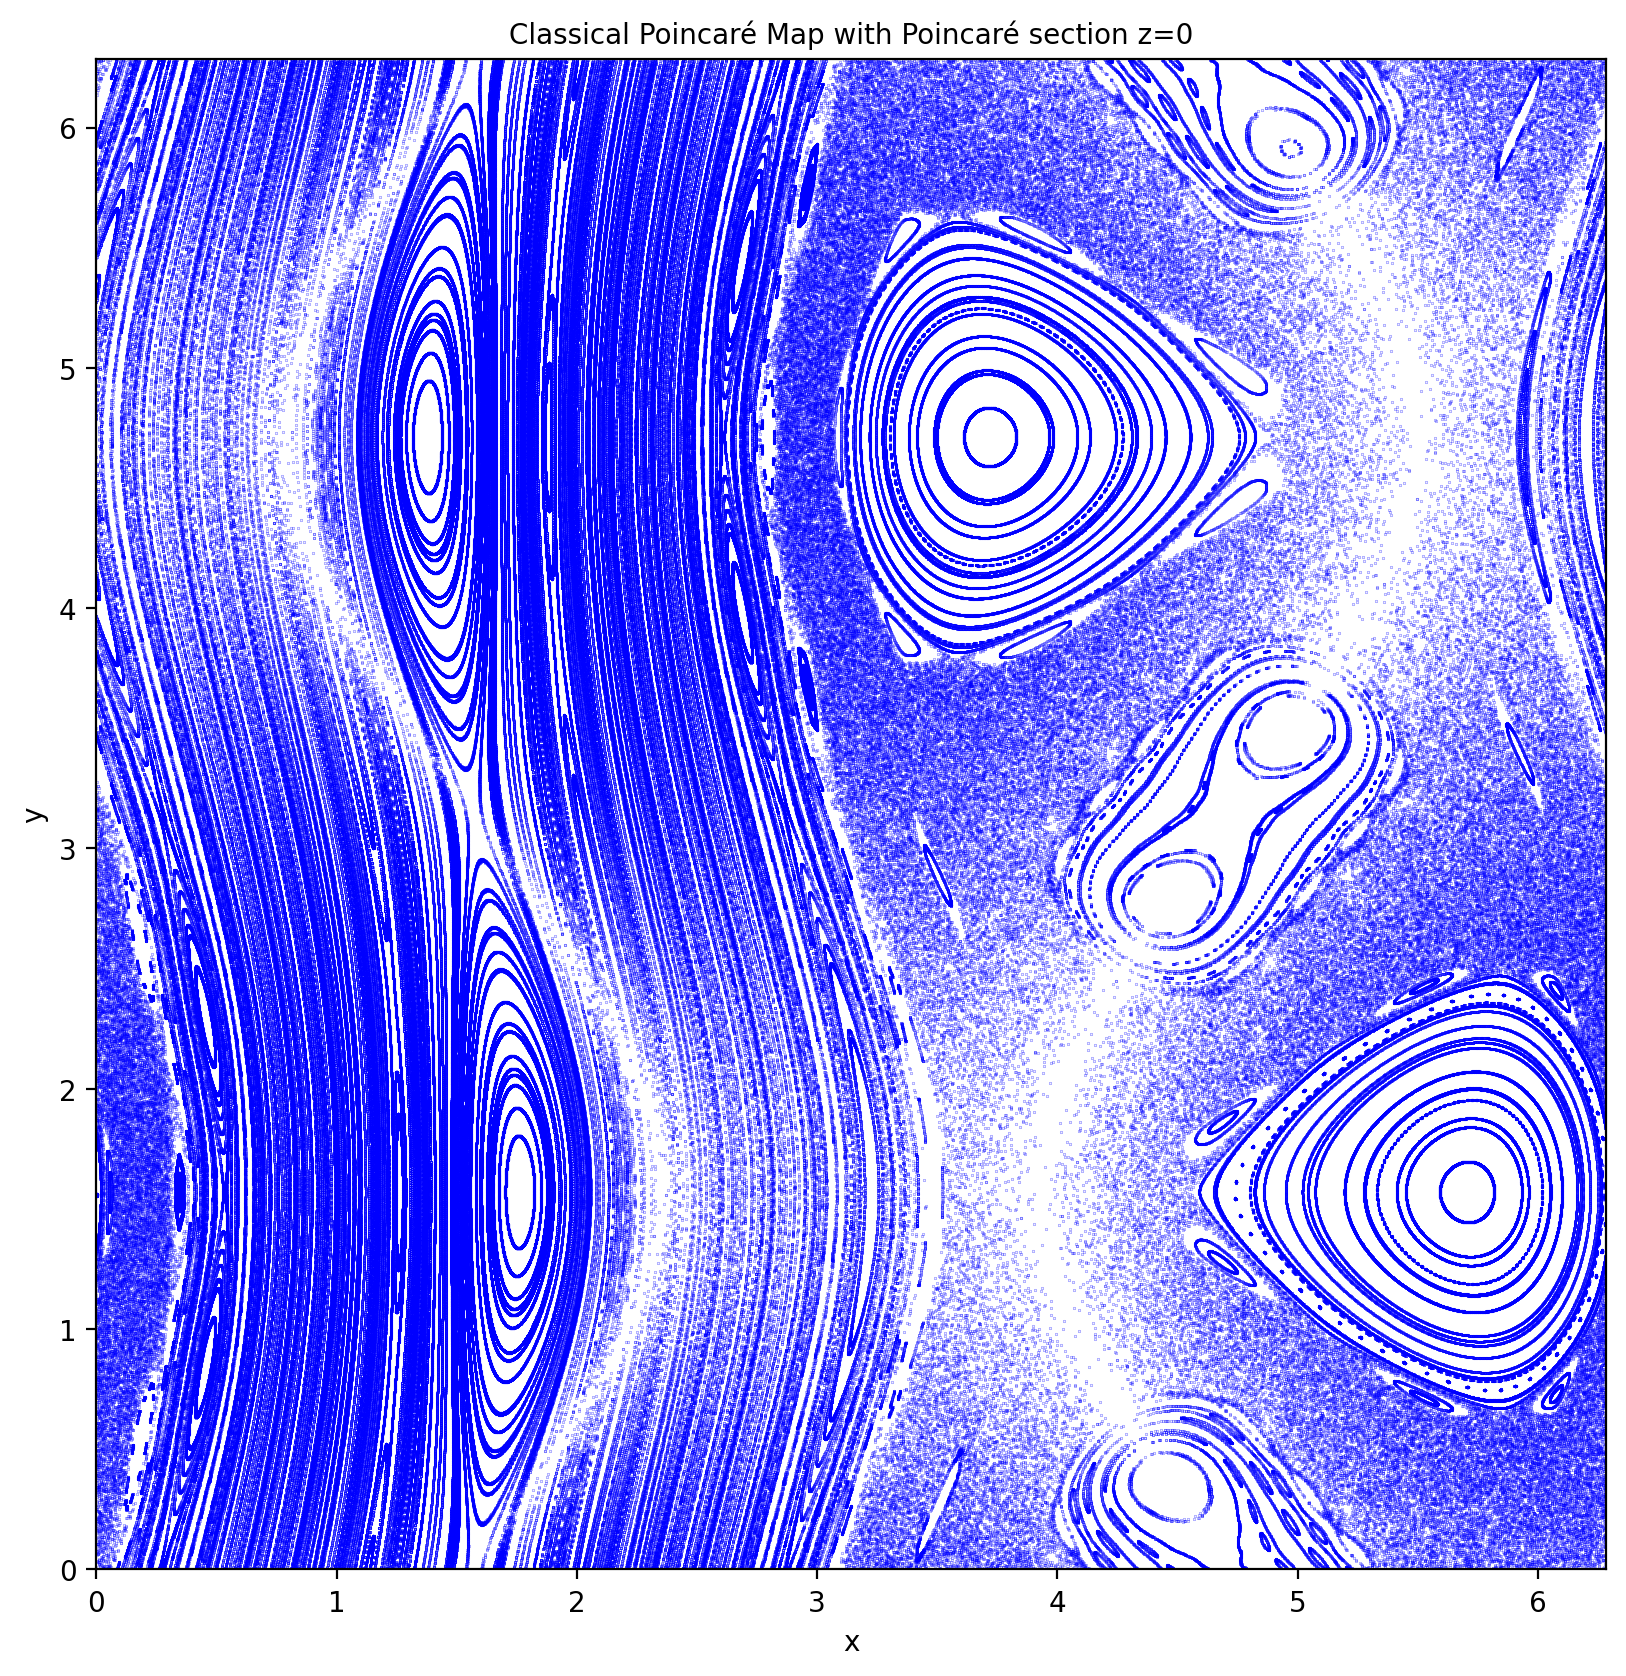

In [9]:
############################################ PLOT RESULTS ############################################

# Import plotting libraries
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(10, 10), dpi = 200)
ax = plt.axes()

# Poincare Map
ax.scatter(x_intersec, y_intersec, c = "b", s = 0.01)

# Axis Labels
ax.set_xlabel("x", fontsize = 10)
ax.set_ylabel("y", fontsize = 10)

# Axis limits
ax.set_xlim([0, 2*pi])
ax.set_ylim([0, 2*pi])

# Title
ax.set_title(r'Classical Poincaré Map with Poincaré section z=0', fontsize = 10)

ax.set_aspect('equal')

plt.show()

The plot reveals vortical regions surrounded by a chaotic sea. Each of the vortical regions contains a family of invariant tori that act as transport barriers.

# References

[1] Notebook 2.2. in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.

[2] [YouTube Tutorial](https://youtu.be/P9ZWlaQGnRI)